In [1]:
from VectorMC import *
# generate set of replicas = [m_a,m_b,m_c] each (N,D)
def dAT_replicas(nr,savepath, B=1000,
                      prop='local',
                      steps=.5,
                      x_mult=1,
                      random_m0=False):
    N,D = 64,32
    x,J,m = load_generic_xJM(N,D)
    x = x * x_mult
    if random_m0:
        m = np.random.normal(size=(N,D))
        m = m / np.linalg.norm(m, axis=1,keepdims=True)
    model = VectorSpinMC(B=B, init_xJm=[x,J,m], proposal_type=prop,threshold=0.005, reduction_type='N')
    m_replicas = np.empty(shape=(nr,N,D))
    for n in range(nr):
        m_hist = model.fast_long_run(million_steps=steps,verbose=False,equilibrate=True)
        m_replicas[n] = m_hist[-1]
    np.save(f'C:\\Users\\ilove\\PycharmProjects\\MScThesis1_SpinTransformer\\replicas\\dAT\\{savepath}.npy',m_replicas)
    return m_replicas

# for each pair of replicas, calculate overlap & covariance

def overlap_matrix(replicas):
    nr,N,D = np.shape(replicas)
    overlap_matrix = np.zeros(shape=(nr,nr))
    for i in range(nr):
        for j in range(nr):
            if i <= j:
                overlap = 0
                for n in range(N):
                    overlap += np.dot(replicas[i][n],replicas[j][n])/N
                overlap_matrix[i][j] = overlap
    return overlap_matrix

def overlap_variance(overlap):
    ovp = np.copy(overlap)
    ovp[ovp==0] = np.nan
    ovp = ovp - np.nanmean(ovp)
    ovp[np.isnan(ovp)] = 0
    return ovp, np.nanstd(ovp)

def plot_variance_matrix(Zs_o,titles='123456789'):
    nrows,ncols = np.shape(Zs_o[0])
    Zs_v,Zs_std = [],[]
    for ovp in Zs_o:
        ovp_var,ovp_std = overlap_variance(ovp)
        Zs_v.append(ovp_var)
        Zs_std.append(ovp_std)
    x = np.arange(ncols + 1)
    y = np.arange(nrows + 1)
    if len(Zs_o) == 1:
        fig, ax = plt.subplots(len(Zs_o),figsize=(6,3),sharex=True,sharey=True)
        fig.suptitle(titles)
        ax.set_ylabel('Overlap')
        ax.set_aspect('equal', adjustable='box')
        ax.pcolormesh(x, -y, Zs_o[0], shading='flat', vmin=Zs_o[0].min(), vmax=Zs_o[0].max())
        ax.set_xlim(0, nrows)
        ax.set_ylim(-ncols,0)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        fig, axs = plt.subplots(2,len(Zs_o),figsize=(2*len(Zs_o),4),sharex=True,sharey=True)
        for i in range(len(Zs_o)):
            axs[0,0].set_ylabel('Overlap')
            axs[1,0].set_ylabel('Variance')
            for row in range(2):
                axs[row,i].set_aspect('equal', adjustable='box')
                if row == 0:
                    axs[row,i].pcolormesh(x, -y, Zs_o[i], shading='flat', vmin=np.min(Zs_o), vmax=np.max(Zs_o))
                else:
                    axs[row,i].pcolormesh(x, -y, Zs_v[i], shading='flat', vmin=np.min(Zs_v), vmax=np.max(Zs_v))
                axs[row,i].set_xlim(0, nrows)
                axs[row,i].set_ylim(-ncols,0)
                axs[row,i].set_yticklabels([])
                axs[row,i].set_xticklabels([])
                axs[row,i].set_xticks([])
                axs[row,i].set_yticks([])
        for i in range(len(Zs_o)):
            axs[0,i].set_title(titles[i])
            axs[1,i].set_xlabel(np.round(Zs_std[i],2))
    plt.show()

In [69]:
Bs = [10]
x_mults = [0,0.1,0.2,0.3,0.4,0.5]

for B in Bs:
    for x_mult in x_mults:
        x_replicas = dAT_replicas(5,steps=.5,B=B,x_mult=x_mult,savepath=f'B{B}_x{str(x_mult).replace('.',' ')}',random_m0=True)

In [97]:
print(int(-3))

-3


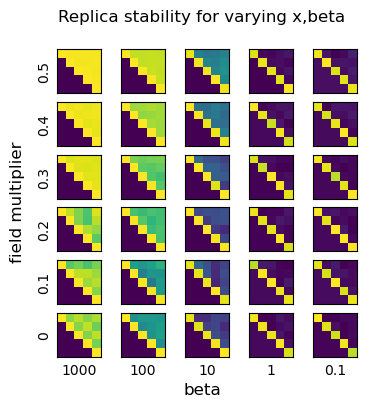

In [128]:
def plot_dAT():
    Bs = [1000,100,10,1,0.1]
    xs = [0.5,0.4,0.3,0.2,0.1,0]
    Zs_o = []
    path = f'C:\\Users\\ilove\\PycharmProjects\\MScThesis1_SpinTransformer\\replicas\\dAT\\'
    for x_mult in xs:
        x_overlaps = []
        for B in Bs:
            x_replicas = np.load(path+f'B{B}_x{str(x_mult).replace('.',' ')}.npy')
            x_olap = overlap_matrix(x_replicas)
            x_overlaps.append(x_olap)
        Zs_o.append(x_overlaps)

    fig, axs = plt.subplots(len(xs),len(Bs),figsize=(4,4),sharex=True,sharey=True)
    for i,x_mult in enumerate(xs):
        for j,B in enumerate(Bs):
            axs[i,j].set_aspect('equal',adjustable='box')
            axs[i,j].pcolormesh(np.arange(6), -np.arange(6), Zs_o[i][j], shading='flat', vmin=np.min(Zs_o[i][j]), vmax=np.max(Zs_o[i][j]))
            axs[i,j].set_xlim(0, 5)
            axs[i,j].set_ylim(-5,0)
            axs[i,j].set_yticklabels([])
            axs[i,j].set_xticklabels([])
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])
            if j == 0:
                axs[i,j].set_ylabel(x_mult)
            if i == 5:
                axs[i,j].set_xlabel(B)
    fig.supxlabel('beta')
    fig.supylabel('field multiplier')
    fig.suptitle('Replica stability for varying x,beta')
    plt.show()

plot_dAT()

In [2]:
Bs = [1000,5,2.5,1.67,1.25,1]
R = (15**0.5)
x_mults = np.round([2.5/R,2.0/R,1.5/R,1.0/R,.5/R,0/R],3)

for B in Bs:
    for x_mult in x_mults:
        x_replicas = dAT_replicas(5,steps=.5,B=B,x_mult=x_mult,savepath=f'B{B}_x{str(x_mult).replace('.',' ')}',random_m0=True)
        print(f'B{B}|x{x_mult},  {np.shape(x_replicas)}')

B1000|x0.645,  (5, 64, 32)
B1000|x0.516,  (5, 64, 32)
B1000|x0.387,  (5, 64, 32)
B1000|x0.258,  (5, 64, 32)
B1000|x0.129,  (5, 64, 32)
B1000|x0.0,  (5, 64, 32)
B5|x0.645,  (5, 64, 32)
B5|x0.516,  (5, 64, 32)
B5|x0.387,  (5, 64, 32)
B5|x0.258,  (5, 64, 32)
B5|x0.129,  (5, 64, 32)
B5|x0.0,  (5, 64, 32)
B2.5|x0.645,  (5, 64, 32)
B2.5|x0.516,  (5, 64, 32)
B2.5|x0.387,  (5, 64, 32)
B2.5|x0.258,  (5, 64, 32)
B2.5|x0.129,  (5, 64, 32)
B2.5|x0.0,  (5, 64, 32)
B1.67|x0.645,  (5, 64, 32)
B1.67|x0.516,  (5, 64, 32)
B1.67|x0.387,  (5, 64, 32)
B1.67|x0.258,  (5, 64, 32)
B1.67|x0.129,  (5, 64, 32)
B1.67|x0.0,  (5, 64, 32)
B1.25|x0.645,  (5, 64, 32)
B1.25|x0.516,  (5, 64, 32)
B1.25|x0.387,  (5, 64, 32)
B1.25|x0.258,  (5, 64, 32)
B1.25|x0.129,  (5, 64, 32)
B1.25|x0.0,  (5, 64, 32)
B1|x0.645,  (5, 64, 32)
B1|x0.516,  (5, 64, 32)
B1|x0.387,  (5, 64, 32)
B1|x0.258,  (5, 64, 32)
B1|x0.129,  (5, 64, 32)
B1|x0.0,  (5, 64, 32)


In [4]:
print([2.5/R,2.0/R,1.5/R,1.0/R,.5/R,0/R])

[0.6454972243679028, 0.5163977794943222, 0.3872983346207417, 0.2581988897471611, 0.12909944487358055, 0.0]


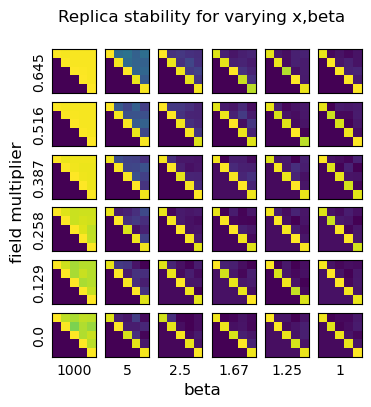

In [6]:
def plot_dAT2():
    Bs = [1000,5,2.5,1.67,1.25,1]
    R = (15**0.5)
    xs = np.round([2.5/R,2.0/R,1.5/R,1.0/R,.5/R,0/R],3)
    Zs_o = []
    path = f'C:\\Users\\ilove\\PycharmProjects\\MScThesis1_SpinTransformer\\replicas\\dAT\\'
    for x_mult in xs:
        x_overlaps = []
        for B in Bs:
            x_replicas = np.load(path+f'B{B}_x{str(x_mult).replace('.',' ')}.npy')
            x_olap = overlap_matrix(x_replicas)
            x_overlaps.append(x_olap)
        Zs_o.append(x_overlaps)

    fig, axs = plt.subplots(len(xs),len(Bs),figsize=(4,4),sharex=True,sharey=True)
    for i,x_mult in enumerate(xs):
        for j,B in enumerate(Bs):
            axs[i,j].set_aspect('equal',adjustable='box')
            axs[i,j].pcolormesh(np.arange(6), -np.arange(6), Zs_o[i][j], shading='flat', vmin=np.min(Zs_o[i][j]), vmax=np.max(Zs_o[i][j]))
            axs[i,j].set_xlim(0, 5)
            axs[i,j].set_ylim(-5,0)
            axs[i,j].set_yticklabels([])
            axs[i,j].set_xticklabels([])
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])
            if j == 0:
                axs[i,j].set_ylabel(x_mult)
            if i == 5:
                axs[i,j].set_xlabel(B)
    fig.supxlabel('beta')
    fig.supylabel('field multiplier')
    fig.suptitle('Replica stability for varying x,beta')
    plt.show()

plot_dAT2()

In [121]:
print(dAT_ovps[4][2][0])
print(np.shape(dAT_ovps))
#dAT_ovps[B{0.1->1k}][x{0->.5}]

T_tester = np.transpose(dAT_ovps,(1,0,2,3))
print(T_tester[2][4][0])
print(np.shape(T_tester))
#dAT_ovps[x{.5->0}][B{1k->0.1}]

[15.00696355 13.60454835 12.1992308  10.827494   14.2211596 ]
(5, 6, 5, 5)
[15.00696355 13.60454835 12.1992308  10.827494   14.2211596 ]
(6, 5, 5, 5)


Recreating the dAT line

[10.0, 3.3333333333333335, 2.0, 1.4285714285714286, 1.1111111111111112, 0.9090909090909091, 0.7692307692307692, 0.6666666666666666]
Completed 3M/50k steps/time for run B=1000


C:\Users\ilove\PycharmProjects\MScThesis1_SpinTransformer\Helpers.py:14: RuntimeWarning: invalid value encountered in scalar divide
  return [float((a[v] @ b[v].T)/(np.linalg.norm(a[v])*np.linalg.norm(b[v]))) for v in range(len(a))]


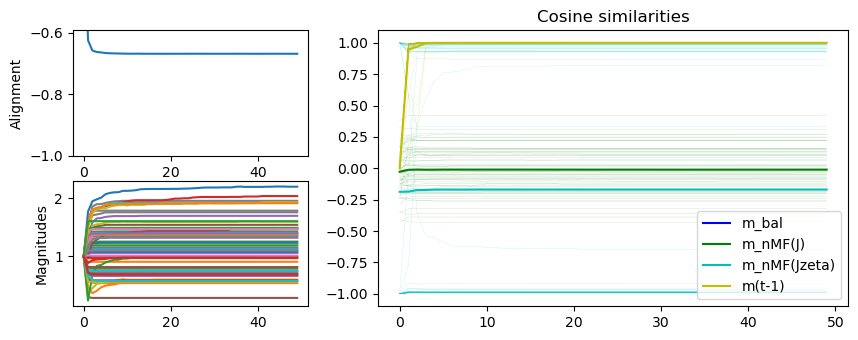

RSB


In [5]:
from VectorMC import *
x,J,m = load_generic_xJM()

Bs = [1000,100,10,1,0.1]
x_mult = [1,0.5,0.3]


model = VectorSpinMC(B=B,init_xJm=[x_mult*x,J,m],reduction_type='N',threshold=0.05)
mhist = model.fast_long_run(million_steps=.5,equilibrate=True)
model.plot_TEs1(mhist)

# for some temperature, what field strength?

In [2]:
a = np.mean(mhist[-1],axis=-1)
print(a)
print(np.shape(a))
print(np.mean(a))

[ 0.41434052 -0.40643423  0.45223139 -0.01195149  0.3886485   0.71090435
  0.0287181  -0.15434699  0.47805183  0.53475795  0.29395538 -0.28656906
 -0.52684728  0.33900075  0.47586365 -0.41033988  0.27734056  0.01943678
 -0.53439298 -0.03771531  0.41145069  0.25457632 -0.51904906  0.43161738
  0.20002585  0.56381345 -0.00229473  0.64180953  0.63633248  0.28257764
  0.34982735 -0.21903962  0.58644224  0.1927013   0.35218155  0.25152138
  0.30503492  0.58710695  0.04800094  0.42364683  0.09100508  0.30017608
 -0.00178218 -0.45196381  0.45591638  0.50807284 -0.13393464  0.5652498
 -0.37589831  0.24739605 -0.46767523  0.65687193  0.73740478  0.27734105
  0.01749214 -0.4185962   0.43851105  0.54891699  0.63329845 -0.42746101
  0.53165879  0.29903789  0.35294104  0.07908448]
(64,)
0.19196874024938915


In [4]:
50000 * 64

3200000